## Decision Tree

En este archivo se hace una prueba de calsificador usando Decision Tree.

De manera independiente se van a cargar las librerías necesarias para el script. A la hora de realizar este script, dado que vamos a usar el arbol de decisiones, solo es necesrio usar Sklearn, Matplotlib para graficar al final, numpy para el procesamiento de los datos y os para moverse entre carpetas.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import os

Como en el resto de códigos, en este la carga de datos se hace de manera similar a las otras. Se cargan los datos desde "load_signal" y se preprocesan los datos y se extraen las características principales desde "preprocess_signal".

In [10]:
def preprocess_signal(signal):

    # Parámetros teóricos
    max_theoretical_value = 230 * np.sqrt(2)

    # Media de la señal
    mean_value = np.mean(signal)

    # Datos sin sesgo
    unbias_data = signal - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    # Cálculo de características
    variance = np.var(unbias_data)  # Varianza
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)  # Asimetría
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3  # Curtosis
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal)[2:4])) / np.abs(np.fft.fft(signal)[1]))  # Distorsión armónica total
    rms = np.sqrt(np.mean(signal ** 2))  # Valor RMS
    crest_factor = np.max(signal) / rms  # Factor de cresta

    # Devuelve todas las características en un vector
    return np.array([variance, skewness, kurtosis, thd, crest_factor])

def load_signal(data_path):

    # Asignar etiquetas explícitamente
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signal": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
    }

    # Inicialización de listas para características y etiquetas
    features = []
    labels = []

    # Iterar por cada tipo de perturbación
    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)

        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)

                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)

                            # Cargar la señal
                            signal = np.load(file_path)

                            # Procesar la señal y extraer características
                            feature_vector = preprocess_signal(signal)

                            # Agregar las características y etiquetas a las listas
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Ejemplo de uso
data_path = "data"  # Ajusta esta ruta según sea necesario
features, labels = load_signal(data_path)

print(f"Características extraídas: {features.shape}")
print(f"Etiquetas extraídas: {labels.shape}")


# Contar las etiquetas únicas en los datos originales 
unique_labels, counts = np.unique(labels, return_counts=True)
print("Etiquetas únicas:", unique_labels)
print("Distribución de señales por categoría:")
for label, count in zip(unique_labels, counts):
    print(f"Clase {label}: {count} señales")

# Verificar que la clase 3 está presente
if 3 not in unique_labels: 
    print("Error: La clase 3 no está presente en los datos originales.")

Características extraídas: (25200, 5)
Etiquetas extraídas: (25200,)
Etiquetas únicas: [0 1 2 3 4 5 6]
Distribución de señales por categoría:
Clase 0: 3600 señales
Clase 1: 3600 señales
Clase 2: 3600 señales
Clase 3: 3600 señales
Clase 4: 3600 señales
Clase 5: 3600 señales
Clase 6: 3600 señales


# Arbol de decisión

Un arbol de decisión es un modelo de clasificación que divide los datos en función de unas reglas basadas en características, formando una estructura interpretable.

Se ha deividido los datos en 70% de test y 15% de pruebas. La precisión se muestra mediante "accuracy" y el reporte de clasificación con los valores de precisión y f1-score de cada clase.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mejor precisión: 0.98
Accuracy del modelo de Árbol de Decisión: 0.97

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       731
           1       0.98      0.98      0.98       713
           2       0.93      0.93      0.93       741
           3       1.00      1.00      1.00       695
           4       0.92      0.92      0.92       743
           5       1.00      1.00      1.00       698
           6       1.00      1.00      1.00       719

    accuracy                           0.97      5040
   macro avg       0.98      0.98      0.98      5040
weighted avg       0.97      0.97      0.97      5040



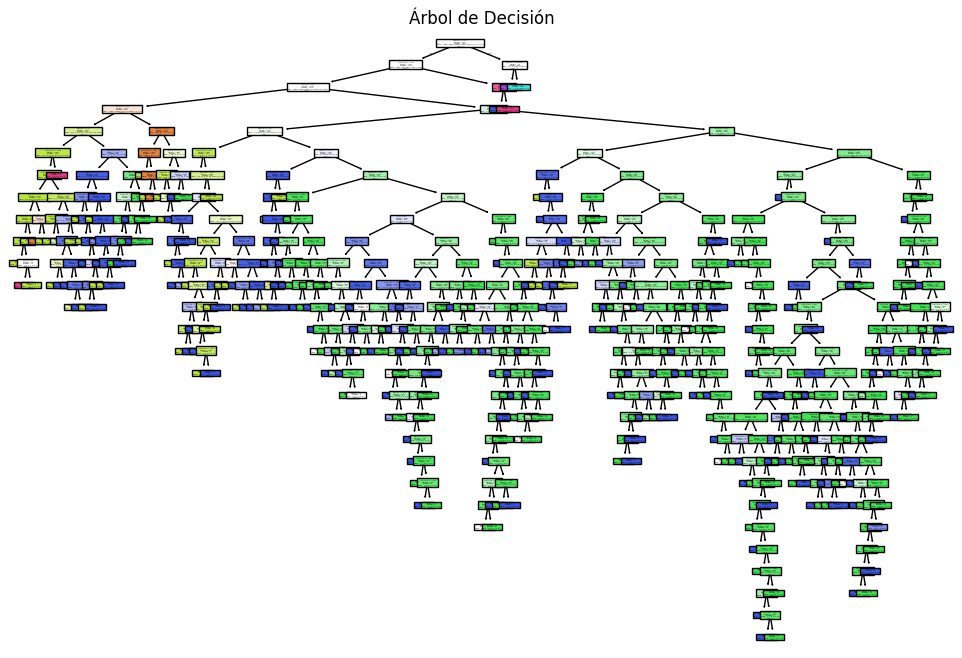

In [11]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Definir los hiperparámetros a buscar
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Crear el modelo base
dt_model = DecisionTreeClassifier(random_state=42)

# Realizar búsqueda en rejilla
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y la mejor puntuación
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión: {grid_search.best_score_:.2f}")

# Entrenar un nuevo modelo con los mejores parámetros
best_dt_model = grid_search.best_estimator_

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo de Árbol de Decisión: {accuracy:.2f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar el árbol de decisión (opcional)
try:
    plt.figure(figsize=(12, 8))
    plot_tree(best_dt_model, 
              feature_names=['variance', 'skewness', 'kurtosis', 'thd', 'crest_factor'],  # Nombres de las características
              class_names=[str(label) for label in np.unique(labels)],  # Clases únicas
              filled=True)
    plt.title("Árbol de Decisión")
    plt.show()
except ImportError:
    print("Para visualizar el árbol, instala 'matplotlib'.")